### Monte Carlo Methods for Reinforcement Learning

**Monte Carlo (MC)** methods are model-free approaches that learn optimal policies through experience sampling, without requiring knowledge of environment dynamics.

**Key Principles:**
- Learn from complete episodes (trajectories)
- Estimate action-value function $Q(s,a)$ from sample returns

- Use first-visit or every-visit averaging**Algorithm:** Sample episodes → Compute returns → Update Q-values → Improve policy

- Apply $\epsilon$-greedy exploration for policy improvement

#### Environment Setup

We use the stochastic **FrozenLake** environment where transitions are probabilistic, making it ideal for demonstrating model-free learning.

In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

env = gym.make("FrozenLake-v1", is_slippery=True)

#### Episode Generation

Generate episodes using **$\epsilon$-greedy exploration**: with probability $\epsilon$, select random action (explore); otherwise, follow policy (exploit). Each episode provides state-action-reward sequences for learning.

In [2]:
def sample_trajectory(pi, env, max_steps=50, epsilon=0.1):
    done = False
    trajectory = []
    num_steps = 0

    state, _ =  env.reset()

    while not done:
        if np.random.rand() < epsilon:
            action = env.action_space.sample() # Explore random action

        else: 
            action = int(pi[state]) # exploit from best known


        next_state, reward, done, _, _ = env.step(action)

        experience = (state, int(action), reward, next_state, done)
        trajectory.append(experience)

        num_steps += 1

        if num_steps >= max_steps:
            # No success
            done = False
            break

        state = next_state

    return trajectory

#### Sample Episode

Test trajectory generation with a random policy. Each trajectory contains $(s_t, a_t, r_t, s_{t+1}, done_t)$ tuples.

In [3]:
policy = np.random.randint(env.action_space.n, size=(env.observation_space.n,))
trajectory = sample_trajectory(policy, env)

trajectory

[(0, 3, 0.0, 0, False),
 (0, 3, 0.0, 0, False),
 (0, 3, 0.0, 0, False),
 (0, 3, 0.0, 0, False),
 (0, 3, 0.0, 0, False),
 (0, 3, 0.0, 0, False),
 (0, 3, 0.0, 0, False),
 (0, 3, 0.0, 1, False),
 (1, 1, 0.0, 5, True)]

#### Example Returns

Demonstrate return calculation for the sampled episode. Each $(s,a)$ pair gets its first-visit return value.

#### Return Calculation

Compute discounted returns $G_t = \sum_{k=0}^{\infty} \gamma^k R_{t+k+1}$ by working backwards from episode end. Uses **first-visit** Monte Carlo approach.

In [4]:
def compute_returns(trajectory, gamma=0.99):
    returns = {}
    G = 0
    for t in reversed(trajectory):
        state, action, reward, _, _ = t

        G = reward + gamma*G

        # first visit
        if (state, action) not in returns:
            returns[(state, action)] = G

    return returns

In [5]:
compute_returns(trajectory)

{(1, 1): 0.0, (0, 3): 0.0}

#### Q-Value Estimation

**Monte Carlo estimation**: $Q(s,a) = \text{average of returns following first visits to } (s,a)$. Collect returns from multiple episodes and average them for each state-action pair.

In [6]:
def monte_carlo_estimate(pi, env, gamma=0.99, max_steps=50, num_episode=5000):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    returns = {(s, a): [] for s in range(env.observation_space.n) for a in range(env.action_space.n)}

    for _ in range(num_episode):
        trajectory = sample_trajectory(pi, env, max_steps)

        returns_for_trajectory = compute_returns(trajectory, gamma)

        for (state, action), G in returns_for_trajectory.items():
            returns[(state, action)].append(G)

    for (state, action), returns_list in returns.items():

        if len(returns_list) > 0:
            Q[state, action] =  np.mean(returns_list)

    return Q

In [7]:
monte_carlo_estimate(policy, env)

array([[0.01529027, 0.0237408 , 0.02221273, 0.02070629],
       [0.01283238, 0.02185069, 0.01815294, 0.02728737],
       [0.04559264, 0.01444578, 0.06760458, 0.0209092 ],
       [0.        , 0.        , 0.00674461, 0.068614  ],
       [0.01746869, 0.        , 0.04029022, 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.0743805 , 0.02390488, 0.074077  , 0.03923626],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.01274572, 0.04669826, 0.        ],
       [0.0106682 , 0.        , 0.        , 0.        ],
       [0.22777507, 0.17779144, 0.17241118, 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.01272857, 0.107811  , 0.2277    , 0.21673289],
       [0.09      , 0.4841629 , 0.98759975, 0.5       ],
       [0.        , 0.        , 0.        , 0.        ]])

#### Policy Improvement

**Greedy policy improvement**: $\pi'(s) = \arg\max_a Q(s,a)$. Select action with highest estimated Q-value for each state.

In [8]:
def policy_improvement(Q):
    return np.argmax(Q, axis=-1)

#### Complete Monte Carlo Algorithm

**Monte Carlo Policy Iteration**: Alternate between policy evaluation (estimate Q-values) and policy improvement (greedy update) until convergence.

In [9]:
def monte_carlo_policy_iteration(env, gamma=0.99, max_steps=50, num_episodes=10000):
    policy = np.random.randint(env.action_space.n, size=(env.observation_space.n,))

    while True:
        Q = monte_carlo_estimate(policy, env, gamma, max_steps, num_episodes)

        new_policy = policy_improvement(Q)

        if np.array_equal(policy, new_policy):
            break

        policy = new_policy

    return policy, Q

#### Learn Optimal Policy

Run complete Monte Carlo policy iteration to find the optimal policy for the stochastic FrozenLake environment.

In [10]:
optimal_policy, optimal_Q = monte_carlo_policy_iteration(env)
print(optimal_policy)

[1 3 0 3 0 0 2 0 3 1 0 0 0 2 1 0]


#### Policy Evaluation

Test the learned optimal policy by measuring success rate over multiple episodes. This validates the effectiveness of Monte Carlo learning.

In [11]:
def test_policy(policy, env, num_episodes=500):
    success_count = 0

    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False

        while not done:
            action = policy[state]
            state, reward, done, _, _ = env.step(action)

            if done and reward == 1.0:  # Reached the goal
                success_count += 1

    success_rate = success_count / num_episodes
    print(f"Policy Success Rate: {success_rate * 100:.2f}%")

test_policy(optimal_policy, env)

Policy Success Rate: 54.60%


### Online Monte Carlo

**Online Monte Carlo** updates Q-values incrementally during learning rather than storing all returns and computing averages at the end.

**Key Advantage:** Memory efficient - no need to store all episode returns

**Update Rule:** 
$$Q(s,a) \leftarrow Q(s,a) + \frac{1}{N(s,a)} [G - Q(s,a)]$$

where $N(s,a)$ is the visit count for state-action pair $(s,a)$.

Applied to Q-learning: each new return $G$ updates the current Q-value estimate using the difference between the new return and current estimate, scaled by the inverse visit count.


In [12]:
def online_monte_carlo_estimate(pi, env, gamma=0.99, max_steps=50, num_episodes=10000):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    N = np.zeros((env.observation_space.n, env.action_space.n))

    for _ in range(num_episodes):
        trajectory = sample_trajectory(pi, env, max_steps)

        returns = compute_returns(trajectory, gamma)

        for (state, action), G in returns.items():
            Q[state, action] = Q[state, action] + (G - Q[state, action]) / (N[state, action] + 1)
            N[state, action] += 1
    

    return Q

In [13]:
def online_monte_carlo_policy_iteration(env, gamma=0.99, max_steps=50, num_episodes=10000):
    policy = np.random.randint(env.action_space.n, size=(env.observation_space.n,))

    while True:
        Q = online_monte_carlo_estimate(policy, env, gamma, max_steps, num_episodes)

        new_policy = policy_improvement(Q)

        if np.array_equal(policy, new_policy):
            break

        policy = new_policy

    return policy, Q

In [14]:
optimal_policy, optimal_Q = monte_carlo_policy_iteration(env)

print(optimal_policy)

[0 3 0 0 0 0 2 0 3 1 0 0 0 2 1 0]


In [15]:
test_policy(optimal_policy, env)

Policy Success Rate: 77.60%


### Learning Rate

**Learning Rate Decay** replaces the visit count $N(s,a)$ with a time-decaying learning rate $\alpha_t$ that decreases over episodes.

**Key Benefits:**
- More controlled learning schedule compared to $1/N(s,a)$ decay
- Prevents learning rate from becoming too small too quickly
- Better convergence properties in practice

**Update Rule:** 
$$Q(s,a) \leftarrow Q(s,a) + \alpha_t [G - Q(s,a)]$$

where $\alpha_t = \max(\alpha_{min}, \alpha_{start} \cdot \gamma^t)$ provides exponential decay with a minimum threshold.

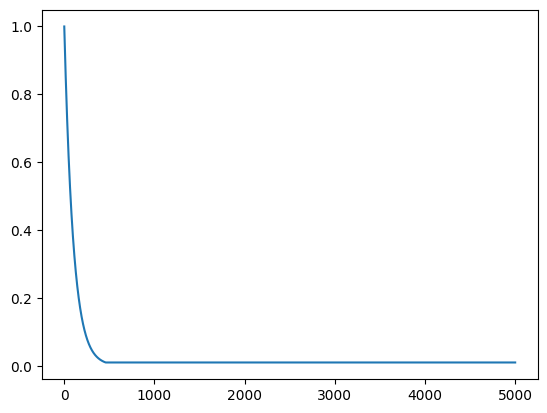

In [16]:
def lr_scheduler(start_val, min_val, decay_factor, num_episodes):

    alphas=[start_val*decay_factor**ep for ep in range(num_episodes)]
    alphas=[a if a>=min_val else min_val for a in alphas]

    return alphas

alphas = lr_scheduler(1.0, 0.01, 0.99, 5000)

plt.plot(alphas)
plt.show()

In [17]:
def online_monte_carlo_estimation_w_lr(pi,
                                       env,
                                       gamma=0.99,
                                       max_steps=50,
                                       num_episodes=5000,
                                       lr_start_val=0.8, 
                                       lr_min_val=0.01, 
                                       lr_decay_factor=0.99):

    Q = np.zeros((env.observation_space.n, env.action_space.n))
    alphas = lr_scheduler(lr_start_val, lr_min_val, lr_decay_factor, num_episodes)

    for i in range(num_episodes):
        trajectory = sample_trajectory(pi, env, max_steps)

        returns = compute_returns(trajectory, gamma)

        for (state, action), G in returns.items():
        
            Q[state, action] = Q[state, action] + alphas[i] * (G - Q[state, action])

    return Q

In [18]:
def monte_carlo_policy_iteration(env, 
                                 gamma=0.99, 
                                 max_steps=50, 
                                 num_episodes=10000,
                                 lr_start_val=0.6, 
                                 lr_min_val=0.01, 
                                 lr_decay_factor=0.98):
    policy = np.random.choice(env.action_space.n, size=(env.observation_space.n, ))

    while True:
        Q = online_monte_carlo_estimation_w_lr(policy, env, gamma, max_steps, num_episodes, lr_start_val, lr_min_val, lr_decay_factor)
        new_policy = policy_improvement(Q)

        if np.array_equal(policy, new_policy):
            break

        policy = new_policy

    return policy, Q

optimal_policy, optimal_Q = monte_carlo_policy_iteration(env)

print(optimal_policy)

[2 3 1 3 0 0 2 0 3 1 1 0 0 2 1 0]


In [19]:
test_policy(optimal_policy, env)

Policy Success Rate: 40.40%
